# Evaluating Website Redesign Impact with A/B Testing


## Business Context and Problem Statement


In this project, a controlled A/B experiment is evaluated to determine whether a new website landing page leads to a meaningful improvement in user conversion compared to the existing design. Users are randomly assigned to either a control group (old landing page) or a treatment group (new landing page), and conversion outcomes are observed. 

The objective of this analysis is to assess whether the observed difference in conversion performance between the two groups is statistically significant and practically meaningful, and to provide a data-driven recommendation on whether the redesigned page should be adopted.

## Dataset Overview

This analysis is based on user-level data from a controlled A/B experiment designed to evaluate the impact of a website landing page redesign on conversion behavior. Each observation represents an individual user interaction recorded during the experiment.

The dataset is structured to allow a comparison between a control group and a treatment group, with conversion outcome as the primary metric of interest. A detailed inspection of the dataset structure and variables is conducted after loading the data.

## Dataset Source

The dataset used in this project was obtained from Kaggle:

- **Source**: Kaggle — A/B Testing Dataset  
- **Link**: https://www.kaggle.com/datasets/zhangluyuan/ab-testing

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

### Load Dataset

In [2]:
df = pd.read_csv("../data/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Dataset Shape

In [3]:
df.shape

(294478, 5)

### Column Names

In [4]:
df.columns.tolist()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

### Data Types

In [5]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

### Missing Values Check

In [6]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Duplicate Rows Check

In [7]:
df.duplicated().sum()

0

### Observations from Initial Data Inspection

The dataset contains 294,478 user-level observations and five variables relevant to a controlled A/B experiment. All variables are present with appropriate data types, and no missing or duplicate records are observed.

### Unique Values in Key Columns

In [8]:
df["group"].unique(), df["landing_page"].unique(), df["converted"].unique()

(array(['control', 'treatment'], dtype=object),
 array(['old_page', 'new_page'], dtype=object),
 array([0, 1], dtype=int64))

### Distribution of Observations by Group

In [9]:
df["group"].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

### Distribution of Observations by Landing Page

In [10]:
df["landing_page"].value_counts()

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

### Group vs Landing Page Cross-Tabulation

In [11]:
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


### Count of Mismatched Group–Page Assignments


In [12]:
mismatch_mask = (
    ((df["group"] == "control") & (df["landing_page"] != "old_page")) |
    ((df["group"] == "treatment") & (df["landing_page"] != "new_page"))
)

mismatch_mask.sum()

3893

### Experiment Hygiene Observations

A small number of observations exhibit inconsistencies between experimental group assignment and the landing page actually shown to users. Specifically, 3,893 observatio ) involve control users exposed to the new page or treatment users exposed to the old page.


### Create Clean Experiment Dataset

In [13]:
df_clean = df[~mismatch_mask].copy()
df_clean.shape

(290585, 5)

### Clean Experiment Dataset Confirmation

After excluding observations with inconsistent group assignment and page exposure, the final analysis dataset contains 290,585 user-level observations. This cleaned dataset preserves the vast majority of the original data while ensuring a valid comparison between users exposed to the old and new landing pages.


## Experiment Definition and Hypotheses

### Objective
Evaluate whether the redesigned landing page (`new_page`) leads to a meaningful change in user conversion

### Unit of Analysis and Groups
- **Unit of analysis**: individual user  
- **Control**: users exposed to `old_page`  
- **Treatment**: users exposed to `new_page`

### Primary Metric
- **Conversion rate (CR)**: the proportion of users who converted  
$$
CR = \frac{\text{Number of converted users}}{\text{Total users}}
$$

### Hypotheses
Let $p_{old}$ denote the conversion rate for the existing landing page and $p_{new}$ denote the conversion rate for the redesigned landing page.

- **Null hypothesis**:  
  $H_0: p_{new} = p_{old}$

- **Alternative hypothesis**:  
  $H_1: p_{new} \neq p_{old}$

### Significance Level
The significance level for the hypothesis test is set to $\alpha = 0.05$


### Test Type
A two-sided hypothesis test is used, as the redesigned landing page could plausibly lead to either an increase or a decrease in conversion rate.

## Conversion Rate Analysis

### Conversion Rate by Landing Page


In [14]:
# Compute conversion rates by landing page using the cleaned dataset
conversion_rates = (
    df_clean
    .groupby("landing_page")["converted"]
    .mean()
)

conversion_rates

landing_page
new_page    0.118807
old_page    0.120386
Name: converted, dtype: float64

### Observed Conversion Rates

The observed conversion rate for the existing landing page is 12.04%, while the redesigned landing page exhibits a conversion rate of 11.88%. At a descriptive level, the redesigned page shows a slightly lower conversion rate compared to the existing design.


### Absolute Difference and Relative Change

In [15]:
p_old = conversion_rates["old_page"]
p_new = conversion_rates["new_page"]

absolute_diff = p_new - p_old
relative_change = absolute_diff / p_old

absolute_diff, relative_change

(-0.0015790565976871451, -0.0131165800315857)

### Conversion Rate Difference and Practical Impact

The redesigned landing page exhibits an absolute conversion rate difference of −0.16 percentage points relative to the existing design, corresponding to an approximate 1.3% decrease in conversion rate. While the magnitude of this difference is small, its direction suggests that the redesigned page performs slightly worse than the existing version at a descriptive level.

## Hypothesis Testing

### Two-Proportion Z-Test

In [16]:
from statsmodels.stats.proportion import proportions_ztest

# Count conversions and total users for each group
conversions = df_clean.groupby("landing_page")["converted"].sum()
n_obs = df_clean.groupby("landing_page")["converted"].count()

# Order: new_page, old_page
count = [conversions["new_page"], conversions["old_page"]]
nobs = [n_obs["new_page"], n_obs["old_page"]]

z_stat, p_value = proportions_ztest(count, nobs, alternative="two-sided")

z_stat, p_value

(-1.3116075339133115, 0.18965258971881804)

## Confidence Interval for Conversion Rate Difference

### 95% Confidence Interval

In [17]:
from scipy.stats import norm

# Extract proportions and sample sizes
p_new = p_new
p_old = p_old

n_new = n_obs["new_page"]
n_old = n_obs["old_page"]

# Standard error for difference in proportions
se_diff = np.sqrt(
    (p_new * (1 - p_new)) / n_new +
    (p_old * (1 - p_old)) / n_old
)

# 95% confidence interval
z_crit = norm.ppf(0.975)  # two-sided 95%
ci_lower = (p_new - p_old) - z_crit * se_diff
ci_upper = (p_new - p_old) + z_crit * se_diff

ci_lower, ci_upper

(-0.003938670329636228, 0.0007805571342619382)

### Statistical Inference Summary and Interpretation

The two-proportion Z-test indicates no statistically significant difference in conversion rates between the redesigned and existing landing pages at the 5% significance level. The observed difference favors the existing landing page, but the associated p-value suggests that this difference could reasonably arise due to random variation.

The 95% confidence interval for the difference in conversion rates includes zero and spans small positive and negative values, indicating that both no effect and small effects in either direction are plausible. Taken together, these results provide insufficient evidence to conclude that the redesigned landing page meaningfully improves conversion performance.


### Conversion Rate Comparison

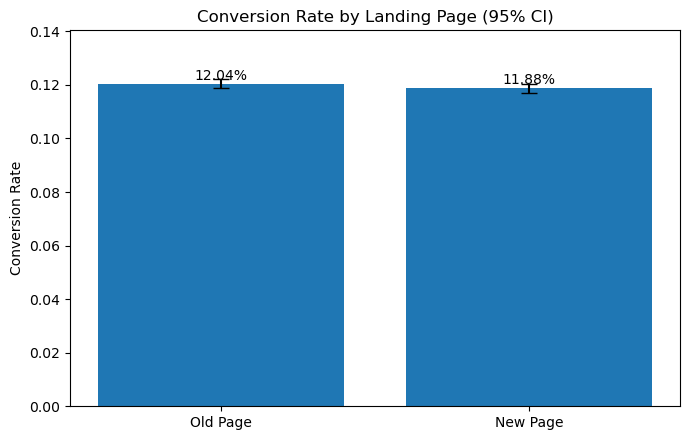

In [18]:
from pathlib import Path

# Compute conversion rate and 95% CI for each landing page
summary = df_clean.groupby("landing_page")["converted"].agg(["mean", "count"])
summary["se"] = np.sqrt(summary["mean"] * (1 - summary["mean"]) / summary["count"])

z_crit = norm.ppf(0.975)  # 95% CI
summary["ci_lower"] = summary["mean"] - z_crit * summary["se"]
summary["ci_upper"] = summary["mean"] + z_crit * summary["se"]

# Ensure consistent ordering
summary = summary.loc[["old_page", "new_page"]]

# Prepare plot inputs
labels = ["Old Page", "New Page"]
rates = summary["mean"].values
yerr = (summary["ci_upper"] - summary["mean"]).values  # symmetric around mean

# Plot
plt.figure(figsize=(7, 4.5))
plt.bar(labels, rates, yerr=yerr, capsize=6)
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Landing Page (95% CI)")
plt.ylim(0, max(summary["ci_upper"]) * 1.15)

# Show values on top of bars (percent)
for i, v in enumerate(rates):
    plt.text(i, v + yerr[i] * 0.15, f"{v*100:.2f}%", ha="center", va="bottom")

plt.tight_layout()

# Save to figures folder
figures_dir = Path("../figures")
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / "conversion_rate_comparison.png", dpi=300)
plt.show()

The conversion rate comparison shows that the redesigned landing page performs slightly worse than the existing page, with substantial overlap in the 95% confidence intervals. This visual summary is consistent with the statistical analysis, which found no significant difference in conversion performance between the two pages.


### Conversion Rate Difference (95% Confidence Interval)

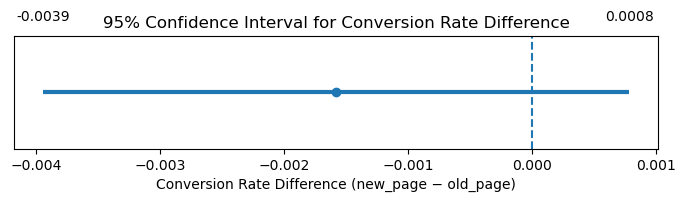

In [21]:
# Difference is defined as: new_page - old_page
diff = p_new - p_old
ci_low, ci_high = ci_lower, ci_upper

plt.figure(figsize=(7, 2.2))

# Horizontal CI line with point estimate
plt.hlines(y=1, xmin=ci_low, xmax=ci_high, linewidth=3)
plt.plot(diff, 1, marker="o")

# Reference line at zero (no difference)
plt.axvline(0, linestyle="--")

plt.yticks([])

plt.xlabel("Conversion Rate Difference (new_page − old_page)")
plt.title("95% Confidence Interval for Conversion Rate Difference")

# Add readable annotations
plt.text(ci_low, 1.07, f"{ci_low:.4f}", ha="center")
plt.text(ci_high, 1.07, f"{ci_high:.4f}", ha="center")

plt.tight_layout()

# Save to figures folder
figures_dir = Path("../figures")
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / "conversion_rate_difference_ci.png", dpi=300)
plt.show()

### Interpretation of Conversion Rate Difference

The 95% confidence interval for the conversion rate difference spans negative and positive values and includes zero, indicating that the observed difference is not statistically significant. While the point estimate suggests a slight decrease in conversion for the redesigned page, the uncertainty around the estimate implies that no reliable improvement can be attributed to the redesign.

## Effect Size and Final Recommendation

### Effect Size (Cohen’s h)

In [23]:
h = 2 * (np.arcsin(np.sqrt(p_new)) - np.arcsin(np.sqrt(p_old)))
h

-0.00486630520161202

### Effect Size Interpretation

The estimated effect size, measured using Cohen’s h, is extremely small in magnitude. This indicates that the difference in conversion rates between the redesigned and existing landing pages is practically negligible. Even with a large sample size, the observed difference does not represent a meaningful change in user behavior.

## Recommendation

Based on the combined evidence from descriptive analysis, hypothesis testing, confidence intervals, and effect size estimation, there is no support for adopting the redesigned landing page. The experiment shows no statistically significant improvement in conversion rate, and the estimated effect size suggests that any true difference is negligible in practical terms.

It is therefore recommended that the redesigned page not be rolled out in its current form. Further experimentation should focus on alternative design changes that are more likely to produce a meaningful impact on user conversion.
